In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "16" # OpenMP will otherwise use all cores
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.float_format = '{:.4f}'.format
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
%load_ext autoreload
%autoreload 2
%matplotlib inline

from perturbseq import *

# Load pre-processed Perturbseq experiment from hdf5

Populations are constructed in notebook *GI generate populations*

In [2]:
pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/final_single_cell_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 32.0204510689s.
Done.


In [3]:
pop.info()

Matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: int32(24665)
memory usage: 8.6 GB

Normalized matrix
<class 'pandas.core.frame.DataFrame'>
Index: 93658 entries, AAACCTGAGGCATGTG-1 to TTTGTCATCTGGCGAC-8
Columns: 24665 entries, ENSG00000243485 to ENSG00000271254
dtypes: float64(24665)
memory usage: 17.2 GB


In [4]:
control_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/control_pop.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 2.6070561409s.
Done.


In [5]:
mean_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/mean_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.197646141052s.
Done.


# Load emap information

In [6]:
# these have different names in the emap and in GChr38
name_replacer = {'C3orf72': 'FOXL2NB',
                 'C19orf26': 'CBARP',
                 'KIAA1804': 'RP5-862P8.2',
                 'RHOXF2': 'RHOXF2B',
                }

inverse_name_replacer = {v: k for k, v in name_replacer.iteritems()}

In [7]:
emap = pd.read_csv('./final_emaps/processed_emap.csv', index_col=[0])
phen_matrix = pd.read_csv('./final_emaps/processed_fitnesses.csv', index_col=[0])
single_phen = pd.read_csv('./final_emaps/single_fitnesses_no_filter.csv', index_col=[0])

In [8]:
# this is average fitness across two guides in primary emap, not single guide used for perturbseq
single_fitnesses = single_phen['average_fitness']

# fitness mapper, maps names to raw fitness values
fitness_mapper = dict()
for perturbation in pop.cells['guide_target'].unique():
    first, second = perturbation.split('_')
    try:
        if 'NegCtrl' in second:
            fitness_mapper[perturbation] = single_fitnesses.loc[first]
        elif 'NegCtrl' in first:
            fitness_mapper[perturbation] = single_fitnesses.loc[second]
        else:
            fitness_mapper[perturbation] = phen_matrix.loc[first, second]
    except KeyError:
        fitness_mapper[perturbation] = np.nan

In [9]:
single_genes = np.intersect1d(reduce(np.union1d, mean_pop.cells.query('num_targets == 1')['guide_target'].map(lambda x: x.split('_'))),
               emap.columns.map(lambda x: name_replacer.get(x, x)))
# we know these don't work...
single_genes = np.setdiff1d(single_genes, ['BAK1', 'BCL2L11'])

# maps gene name to single (SLC38A2 is the lone exception where we don't have it in position 1)
single_gene_perturbations = dict()

for gene in single_genes:
    if gene + '_NegCtrl0' in mean_pop.cells.index:
        single_gene_perturbations[gene] = gene + '_NegCtrl0'
    elif 'NegCtrl0_' + gene in mean_pop.cells.index:
        single_gene_perturbations[gene] = 'NegCtrl0_' + gene
        
double_perturbations = mean_pop.cells.query('num_targets == 2').index
perturbations = single_gene_perturbations.values()

for p in double_perturbations:
    gene1, gene2 = p.split('_')
    if gene1 in single_genes and gene2 in single_gene_perturbations.keys():
        perturbations.append(p)
        
fitnesses = mean_pop.cells.loc[perturbations, 'fitness']

mapper = {v: k for k, v in single_gene_perturbations.iteritems()}

# Restrict to things with transcriptional phenotypes

In [10]:
ks, ps, adj_ps = ks_de(pop,
                       key='guide_target',
                       control_cells='perturbed == "control"',
                       genes='mean > 0.5',
                       normalized=True,
                       alpha=0.001,
                       n_jobs=24)

7353 control cells
groupby: index in @key_barcodes (key = guide_target)


[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=24)]: Done  13 tasks      | elapsed:    7.6s
[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:   11.0s
[Parallel(n_jobs=24)]: Done  37 tasks      | elapsed:   16.1s
[Parallel(n_jobs=24)]: Done  50 tasks      | elapsed:   22.1s
[Parallel(n_jobs=24)]: Done  65 tasks      | elapsed:   26.3s
[Parallel(n_jobs=24)]: Done  80 tasks      | elapsed:   32.1s
[Parallel(n_jobs=24)]: Done  97 tasks      | elapsed:   39.0s
[Parallel(n_jobs=24)]: Done 114 tasks      | elapsed:   44.8s
[Parallel(n_jobs=24)]: Done 133 tasks      | elapsed:   51.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:   57.5s
[Parallel(n_jobs=24)]: Done 173 tasks      | elapsed:  1.1min
[Parallel(n_jobs=24)]: Done 194 tasks      | elapsed:  1.2min
[Parallel(n_jobs=24)]: Done 217 tasks      | elapsed:  1.3min
[Parallel(n_jobs=24)]: Done 240 tasks      | elapsed:  1.5min
[Parallel(n_jobs=24)]: Done 269 out of 287 | elapsed:  1.6min remainin

In [28]:
de_genes = (adj_ps < 0.001).sum().loc[single_gene_perturbations.values()]
good_genes = np.intersect1d(de_genes[de_genes > 10].index.map(lambda x: mapper[x]), emap.columns)
good_perturbations = [single_gene_perturbations[x] for x in good_genes]

# Make linkages used for clustering figures

In [12]:
single_mean_pop = CellPopulation.from_hdf('/home/tmn/sequencing/gi/gi/outs/single_mean_pop_with_normalized.hdf')

Loading matrix...
Loading normalized matrix...
Loading metadata...
Done in 0.115160942078s.
Done.


In [13]:
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import pdist, squareform
from matplotlib import colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

In [14]:
#### colormap
#'#20B6E2' -> '#F4EA18'
# 32,182,226 -> 244,234,24
# .125, .713, .886 -> .957, .918, .094
cdict = {'red':((0.0,0.125,0.125),
                (0.5,0.0,0.0),
                (1.0,0.957,0.957)),
        'green':((0.0,0.713,0.713),
                (0.5,0.0,0.0),
                (1.0,0.918,0.918)),
        'blue': ((0.0,0.886,0.886),
                (0.5,0.0,0.0),
                (1.0,0.094,0.094))}
blue_yellow = matplotlib.colors.LinearSegmentedColormap('BlueYellow',cdict)
blue_yellow.set_bad((.9, .9, .9, 1.0))
plt.register_cmap(cmap=blue_yellow)

These are the GI map and corresponding fitness measurements for the perturbations selected in the previous section

In [15]:
good_emap = emap.loc[good_genes, good_genes]
good_phen = phen_matrix.loc[good_genes, good_genes]

Z_emap = linkage(good_emap, method='ward')
Z_phen = linkage(good_phen, method='ward')

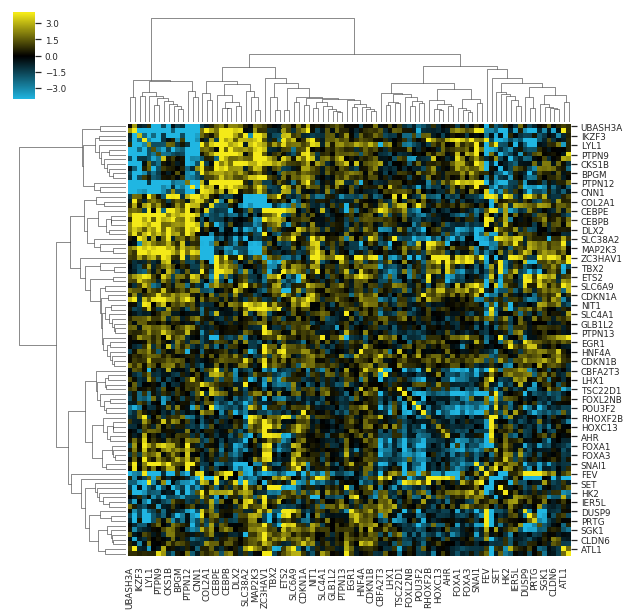

In [16]:
sns.set(font_scale=0.8)
cg = sns.clustermap(good_emap,
                    row_linkage=Z_emap,
                    col_linkage=Z_emap,
                    cmap='BlueYellow',
                    vmin=-4, vmax=4, figsize=[10,10])

# Routines for performing GI prediction

This routine is for subsampling/masking a (symmetric) DataFrame given a list of entries that are observed

In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
import scipy
from maxide import *

def get_masked_data(df, ind, mean_normalize=False):
    masked_data = df.copy().values
    mask = pd.DataFrame(0, index=df.index, columns=df.columns)
    
    for gene1, gene2 in ind:
        mask.loc[gene1, gene2] = 1 

    # assume DataFrame is symmetric
    mask = mask + mask.T
    mask = (mask != 0).values
    masked_data[~mask] = 0
    masked_data_df = pd.DataFrame(masked_data, index=df.index, columns=df.columns)
    
    # whether to center the observed entries such that the overall mean is 0
    if mean_normalize:
        masked_data_df = masked_data_df.stack()
        offset = masked_data_df[masked_data_df != 0]
        offset = offset.mean()
        masked_data_df[masked_data_df != 0] = masked_data_df[masked_data_df != 0] - offset
        print offset
        masked_data_df = masked_data_df.unstack()
    
    return masked_data_df, mask

## GI prediction

This is the core predictive routine, which executes the pipeline diagrammed in Fig. S14 of the paper.

1. Subsample the input matrix according to which entries have been observed
2. Fit a quadratic model that predicts the fitness of a double perturbation from the fitnesses of the constituent single perturbations
3. Subtract the predicted fitness from the quadratic model from the observed double fitnesses to produce "deltas" (i.e. differences between expected and observed)
4. Predict all unobserved deltas using Maxide matrix completion
5. Transform predicted deltas into predicted fitnesses by adding back the expectations from the quadratic model

In [18]:
def delta_predict(data, side1, side2, sampling, phen_mapper, ground_truth=None, maxide_delta=5e-4, maxide_max_iter=50000,
                  corr_method='spearman', plot_correlation=True, plot_map=False, map_linkage=None, cmap='RdBu_r'):
    
    masked_data, mask = get_masked_data(data, sampling)
    if isinstance(side1, pd.DataFrame):
        side1 = side1.copy().values
    if isinstance(side2, pd.DataFrame):
        side2 = side2.copy().values

    upper_masked_data = upper_triangle(masked_data)
    predicted = upper_masked_data[upper_masked_data == 0].index
    given = upper_masked_data[upper_masked_data != 0].index
        
    delta_tot, X, X_tot, y, y_tot, transformer = get_deltas(data, masked_data, phen_mapper)  
    delta, delta_mask = get_masked_data(delta_tot, sampling)
        
    delta_pred, Z = Maxide(delta.values,
                     np.flatnonzero(delta.values.flatten()),
                     side1,
                     side2,
                     delta=maxide_delta,
                     max_iter=maxide_max_iter)
    delta_pred = pd.DataFrame(delta_pred, index=data.index, columns=data.columns)
    
    pred = pd.Series(transformer.predict(X_tot), index=y_tot.index).unstack() + delta_pred
    
    if ground_truth is None:
        ground_truth = data
    upper_ground = upper_triangle(ground_truth)
    upper_pred = upper_triangle(pred)
    
    if plot_correlation:
        plt.figure()
        plt.scatter(upper_ground.loc[predicted], upper_pred.loc[predicted])
        plt.scatter(upper_ground.loc[given], upper_pred.loc[given])

    if plot_map:
        if map_linkage is None:
            sns.clustermap(pred, method='ward', cmap=plt.cm.get_cmap(cmap), robust=True)
        else:
            sns.clustermap(pred, row_linkage=map_linkage, col_linkage=map_linkage, cmap=plt.cm.get_cmap(cmap), robust=True)
    
    predicted_corr = upper_ground.loc[predicted].corr(upper_pred.loc[predicted], method=corr_method)
    total_corr = upper_ground.corr(upper_pred, method=corr_method)
    
    print('')
    print('Total correlation ({0}): {1}'.format(corr_method, total_corr))
    print('Correlation on predicted ({0}): {1}'.format(corr_method, predicted_corr))
    return pred

def get_deltas(source_data, sampled_data, phen_mapper):
    # this is the routine that fits a quadratic model to observed fitness measurements and returns
    # the deviations from the expectation given by that model (the "deltas")
    y = sampled_data.stack()
    y = y[y != 0]
    
    X = np.concatenate([y.index.get_level_values(0).map(lambda x: phen_mapper[x]).values[:, np.newaxis],
                        y.index.get_level_values(1).map(lambda x: phen_mapper[x]).values[:, np.newaxis]], axis=1)
    
    y_tot = source_data.loc[good_genes, good_genes].stack()
    X_tot = np.concatenate([y_tot.index.get_level_values(0).map(lambda x: phen_mapper[x]).values[:, np.newaxis],
                            y_tot.index.get_level_values(1).map(lambda x: phen_mapper[x]).values[:, np.newaxis]], axis=1)
    
    transformer = PolynomialFeatures()
    model = make_pipeline(PolynomialFeatures(), LinearRegression())
    model.fit(X, y)
    
    delta = pd.Series(y_tot - model.predict(X_tot), index=y_tot.index)
    delta = delta.unstack()
    
    return delta, X, X_tot, y, y_tot, model

For completeness, the routine below does not fit the quadratic model and instead uses Maxide to directly predict the unobserved fitnesses. In our hands this did not work as well.

In [19]:
def raw_predict(data, side1, side2, sampling, ground_truth=None, maxide_delta=5e-4, maxide_max_iter=50000,
                corr_method='spearman', plot_correlation=True, plot_map=False, map_linkage=None, cmap='RdBu_r'):
    
    masked_data, mask = get_masked_data(data, sampling)
    if isinstance(side1, pd.DataFrame):
        side1 = side1.copy().values
    if isinstance(side2, pd.DataFrame):
        side2 = side2.copy().values

    upper_masked_data = upper_triangle(masked_data)
    predicted = upper_masked_data[upper_masked_data == 0].index
    given = upper_masked_data[upper_masked_data != 0].index
        
    pred, Z = Maxide(masked_data.values,
                     np.flatnonzero(masked_data.values.flatten()),
                     side1,
                     side2,
                     delta=maxide_delta,
                     max_iter=maxide_max_iter)
    pred = pd.DataFrame(pred, index=data.index, columns=data.columns)
    
    if ground_truth is None:
        ground_truth = data
    upper_ground = upper_triangle(ground_truth)
    upper_pred = upper_triangle(pred)
    
    if plot_correlation:
        plt.figure()
        plt.scatter(upper_ground.loc[predicted], upper_pred.loc[predicted])
        plt.scatter(upper_ground.loc[given], upper_pred.loc[given])

    if plot_map:
        if map_linkage is None:
            sns.clustermap(pred, method='ward', cmap=plt.cm.get_cmap(cmap), robust=True)
        else:
            sns.clustermap(pred, row_linkage=map_linkage, col_linkage=map_linkage, cmap=plt.cm.get_cmap(cmap), robust=True)
    
    predicted_corr = upper_ground.loc[predicted].corr(upper_pred.loc[predicted], method=corr_method)
    total_corr = upper_ground.corr(upper_pred, method=corr_method)
    
    print('')
    print('Total correlation ({0}): {1}'.format(corr_method, total_corr))
    print('Correlation on predicted ({0}): {1}'.format(corr_method, predicted_corr))
    return pred

## GI map construction

These are the core routines for constructing a fitness GI map, taken from Horlbeck et al., "Mapping the Genetic Landscape of Human Cells", Cell 2018

In [20]:
from scipy import optimize

#for a specified variable position and sgRNA, get single phenotypes, double phenotypes, and optionally single phenotype std dev.
def getXYB(sgRNA, singlePhenotypes, phenotypeMatrix, variablePosition, fixedPosition, returnXerr=False):
    if not returnXerr:
        return singlePhenotypes[variablePosition+'.mean'], \
            phenotypeMatrix.loc[sgRNA,:] if fixedPosition == 'a' else phenotypeMatrix.loc[:,sgRNA], \
            singlePhenotypes.loc[sgRNA, fixedPosition +'.mean']
    else:
        return singlePhenotypes[variablePosition+'.mean'], \
            phenotypeMatrix.loc[sgRNA,:] if fixedPosition == 'a' else phenotypeMatrix.loc[:,sgRNA], \
            singlePhenotypes.loc[sgRNA, fixedPosition +'.mean'], singlePhenotypes[variablePosition+'.std']
            
def quadFitForceIntercept(xdata, ydata, bdata):
    m1 = optimize.fmin(lambda m, x, y: ((m[0]*(x**2) + m[1]*x + bdata - y)**2).sum(), x0=[0.1,0.1], args=(xdata, ydata), disp=0)
    
    return lambda x1: m1[0]*(np.array(x1)**2) + m1[1]*np.array(x1) + bdata            

#calculate epistasis interactions, optionally z-standardizing based on negative controls
def calculateInteractions(phenotypeMatrix, singlePhenotypes, fitFunction, zstandardize=True):
    emap1 = pd.DataFrame(np.zeros(phenotypeMatrix.shape), index=phenotypeMatrix.index, columns=phenotypeMatrix.columns)
    variablePosition, fixedPosition = 'a','b'
    for i, sgRNA in enumerate(phenotypeMatrix.index):
        xdata, ydata, bdata = getXYB(sgRNA, singlePhenotypes, phenotypeMatrix, variablePosition, fixedPosition)
        
        fit = fitFunction(xdata, ydata, bdata)
        epistasis = ydata - fit(xdata)

        if zstandardize:
            emap1.loc[sgRNA,:] = epistasis / epistasis.loc[singlesTable['gene'] == 'negative'].std()
        else:
            emap1.loc[sgRNA,:] = epistasis 

    emap2 = pd.DataFrame(np.zeros(phenotypeMatrix.shape), index=phenotypeMatrix.index, columns=phenotypeMatrix.columns)
    variablePosition, fixedPosition = 'b','a'
    for i, sgRNA in enumerate(phenotypeMatrix.index):
        xdata, ydata, bdata = getXYB(sgRNA, singlePhenotypes, phenotypeMatrix, variablePosition, fixedPosition)
        
        fit = fitFunction(xdata, ydata, bdata)
        epistasis = ydata - fit(xdata)

        if zstandardize:
            emap2.loc[sgRNA,:] = epistasis / epistasis.loc[singlesTable['gene'] == 'negative'].std()
        else:
            emap2.loc[sgRNA,:] = epistasis 

    emap12 = (emap1+emap2)/2
    
    emap_ave = (emap12 + emap12.T) / 2
    
    return emap1, emap2, emap_ave

Wrapper routine for constructing an emap from predictions

In [21]:
def construct_emap(pred, ground_truth, single_fitnesses, sampling=None,
                   corr_method='spearman', plot_correlation=True, plot_map=False, map_linkage=None, cmap='RdBu_r', figsize=[7, 7]):
    
    emap1, emap2, emap = calculateInteractions(pred.loc[good_genes, good_genes],
                                               single_fitnesses.loc[good_genes],
                                               quadFitForceIntercept,
                                               zstandardize=False)
    
    if sampling is not None:
        masked_data, mask = get_masked_data(ground_truth, sampling)
        upper_masked_data = upper_triangle(masked_data)
        predicted = upper_masked_data[upper_masked_data == 0].index
        given = upper_masked_data[upper_masked_data != 0].index
    else:
        upper_masked_data = upper_triangle(ground_truth)
        predicted = upper_masked_data.index
        given = None
    
    if ground_truth is None:
        ground_truth = data
    upper_ground = upper_triangle(ground_truth)
    upper_pred = upper_triangle(emap)
    
    if plot_correlation:
        plt.figure()
        plt.scatter(upper_ground.loc[predicted], upper_pred.loc[predicted])
        if given is not None:
            plt.scatter(upper_ground.loc[given], upper_pred.loc[given])

    if plot_map:
        if map_linkage is None:
            cg = sns.clustermap(emap, method='ward', cmap=plt.cm.get_cmap(cmap), robust=True, figsize=figsize)
        else:
            cg = sns.clustermap(emap, row_linkage=map_linkage, col_linkage=map_linkage, cmap=plt.cm.get_cmap(cmap), robust=True, figsize=figsize)
    
    predicted_corr = upper_ground.loc[predicted].corr(upper_pred.loc[predicted], method=corr_method)
    total_corr = upper_ground.corr(upper_pred, method=corr_method)
    
    print('')
    print('Total correlation ({0}): {1}'.format(corr_method, total_corr))
    print('Correlation on predicted ({0}): {1}'.format(corr_method, predicted_corr))
    return emap

# Generating predictions

In [22]:
import cPickle as pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [23]:
fitness_df = pd.DataFrame(single_fitnesses).rename(columns={'average_fitness': 'a.mean'})
fitness_df['b.mean'] = fitness_df['a.mean']
# maps gene names to the fitness of the corresponding single perturbation
fitness_mapper_gene = {k.replace('_NegCtrl0', '').replace('NegCtrl0_', ''): v for k, v in fitness_mapper.iteritems()}

Baseline GI map to compare to. There are two differences between this and the one in Figure 1:
1. It is recalculated based only on the genes that showed transcriptional phenotypes in the Perturb-seq experiment
2. It is not normalized with respect to negative control sgRNAs (which would then necessitate making many more fitness measurements)

In [24]:
emap1, emap2, emap_baseline = calculateInteractions(phen_matrix.loc[good_genes, good_genes],
                                                    fitness_df.loc[good_genes], quadFitForceIntercept, zstandardize=False)

Perturbseq side information

In [25]:
import scipy 

raw_expr = single_mean_pop.where(genes='mean > 0.2')
raw_expr.index = raw_expr.index.map(lambda x: mapper[x])
raw_expr = (raw_expr - raw_expr.min())/(raw_expr.max() - raw_expr.min())

side = scipy.linalg.sqrtm(raw_expr.loc[good_genes].T.corr())

In [26]:
from collections import defaultdict

In [27]:
samplings = [5, 10, 15, 20, 25]
iters = np.arange(0, 50)

This will perform 50 random samplings at the sampling levels of 5% - 25% and compute the associated predicted GI maps.

In [ ]:
maps = defaultdict(dict)
corrs = defaultdict(dict)

for sample in samplings:
    for it in iters:
        print('Sampling {0}% (it: {1})'.format(sample, it))
        random_sampling = upper_triangle(good_phen, k=0).sample(frac=float(sample)/100., replace=False).index

        random_pred = delta_predict(good_phen, side, side, random_sampling,
                      fitness_mapper_gene, ground_truth=good_phen,
                      plot_map=False, plot_correlation=False, map_linkage=Z_phen, cmap='Purples')

        random_emap = construct_emap(random_pred.loc[good_genes, good_genes],
                                     emap_baseline.loc[good_genes, good_genes],
                                     fitness_df, sampling=random_sampling, plot_map=False, plot_correlation=False, map_linkage=Z_emap, cmap='BlueYellow')

        corr = upper_triangle(random_emap).corr(upper_triangle(emap_baseline), method='spearman')
        
        maps[(sample, it)]['sampling'] = random_sampling
        maps[(sample, it)]['fitness'] = random_pred
        maps[(sample, it)]['emap'] = random_emap
        
        corrs[sample][it] = corr

Store results

In [30]:
# corrs_df = pd.DataFrame(corrs)
# save_obj(maps, './data_sharing/maps_random_sampling')
# corrs_df.to_csv('./data_sharing/maps_random_sampling_corrs.csv')

# Diagram of pipeline

This is the code to generate the panels in Fig. S14A, which may be helpful for understanding how things work.

The pickeled file `maps_random_sampling.pkl` needed below can be downloaded from:

https://www.dropbox.com/s/i2e368nj5dov08t/maps_random_sampling.pkl?dl=0

In [31]:
# these are all the iterations that were used to generate the figures in the paper
maps = load_obj('./data_sharing/maps_random_sampling')

# the particular iteration that was used to generate the main text figure panels
random_sampling = maps[(10, 0)]['sampling']

In [32]:
# fit quadratic model and extract deltas
masked_data, mask = get_masked_data(good_phen, random_sampling)
delta_tot, X, X_tot, y, y_tot, transformer = get_deltas(good_phen, masked_data, fitness_mapper_gene)  
delta, delta_mask = get_masked_data(delta_tot, random_sampling)

In [33]:
lr = transformer.get_params()['linearregression']

xv = np.linspace(-0.6, 0.1, 20)
yv = np.linspace(-0.6, 0.1, 20)
xv, yv = np.meshgrid(xv, yv)
XX = np.concatenate([xv.reshape(400, 1), yv.reshape(400, 1)], axis=1)

z = transformer.predict(XX)
z = z.reshape(20, 20)

Plot fitted quadratic model

In [34]:
from mpl_toolkits.mplot3d import Axes3D

In [35]:
def figure_styles():
    sns.set(font_scale=1.)

    SMALL_SIZE = 12
    MEDIUM_SIZE = 14
    BIGGER_SIZE = 18

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    sns.set_style('white')

In [36]:
figure_styles()

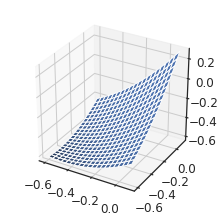

In [37]:
fig = plt.figure(figsize=[3.5, 3.5])
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xv, yv, z)
plt.savefig('./figures/prediction_quadratic_fit.pdf', bbox_inches='tight')

Underlying total fitness measurements

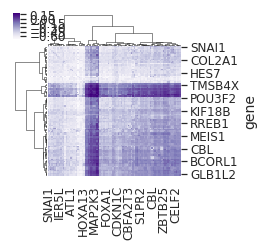

In [38]:
cg = sns.clustermap(good_phen,
                    row_linkage=Z_phen,
                    col_linkage=Z_phen,
                    cmap=plt.cm.get_cmap('Purples'),
                    figsize=[3,3],
                    vmin=-0.7, vmax=0.2)
cg.savefig('./figures/prediction_raw_fitness.pdf')

The 10% of fitnesses that were sampled

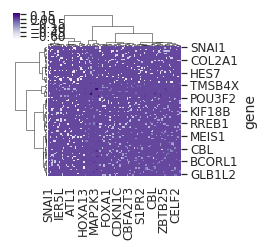

In [39]:
cg = sns.clustermap(masked_data,
                    row_linkage=Z_phen,
                    col_linkage=Z_phen,
                    cmap=plt.cm.get_cmap('Purples'),
                    figsize=[3,3],
                    vmin=-0.7, vmax=0.2)
cg.savefig('./figures/prediction_sampled_fitness.pdf')

Equivalent panels for deltas (raw fitness - expectation from quadratic model)

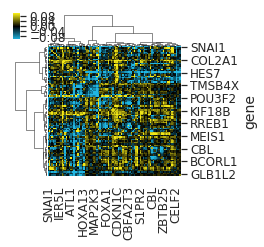

In [40]:
cg = sns.clustermap(delta_tot, row_linkage=Z_phen, col_linkage=Z_phen,
                    cmap=plt.cm.get_cmap('BlueYellow'),
                    figsize=[3,3], vmin=-0.1, vmax=0.1)
cg.savefig('./figures/prediction_deltas.pdf')

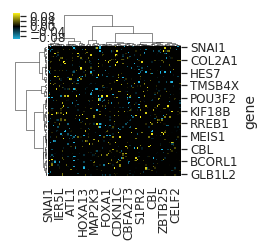

In [41]:
cg = sns.clustermap(delta, row_linkage=Z_phen, col_linkage=Z_phen,
                    cmap=plt.cm.get_cmap('BlueYellow'),
                    figsize=[3,3], vmin=-0.1, vmax=0.1)
cg.savefig('./figures/prediction_delta_masked.pdf')

Predicted GI maps after applying the model from Horlbeck et al., "Mapping the Genetic Landscape of Human Cells", Cell 2018. Note the similarities to the deltas above. The difference is that in Horlbeck et al. the quadratic fit is performed on a per gene basis. These panels are clustered according to the fitness measurements which is why they do not look very blocky.

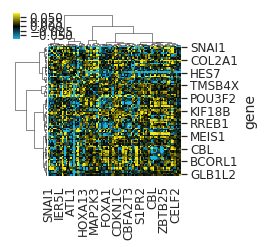

In [42]:
cg = sns.clustermap(emap_baseline,
                    row_linkage=Z_phen,
                    col_linkage=Z_phen,
                    cmap=plt.cm.get_cmap('BlueYellow'),
                    figsize=[3,3], vmin=-0.07, vmax=0.07)
cg.savefig('./figures/prediction_emap_for_comparison.pdf')

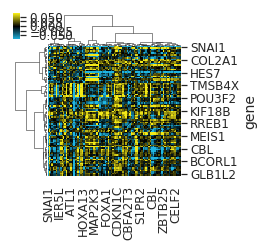

In [43]:
cg = sns.clustermap(maps[(10, 0)]['emap'],
                    row_linkage=Z_phen,
                    col_linkage=Z_phen,
                    cmap=plt.cm.get_cmap('BlueYellow'),
                    figsize=[3,3], vmin=-0.07, vmax=0.07)
cg.savefig('./figures/prediction_predicted_emap.pdf')

Predicted fitness measurements

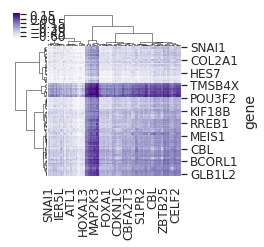

In [44]:
cg = sns.clustermap(maps[(10, 0)]['fitness'],
                    row_linkage=Z_phen,
                    col_linkage=Z_phen,
                    cmap=plt.cm.get_cmap('Purples'),
                    figsize=[3,3],
                    vmin=-0.7, vmax=0.2)
cg.savefig('./figures/prediction_predicted_fitness.pdf')

Predicted deltas

In [45]:
delta_pred = maps[(10, 0)]['fitness'] - pd.Series(transformer.predict(X_tot), index=y_tot.index).unstack()

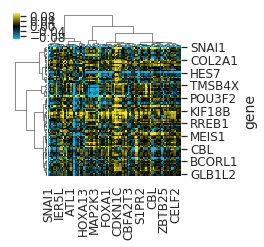

In [46]:
cg = sns.clustermap(delta_pred, row_linkage=Z_phen, col_linkage=Z_phen,
                    cmap=plt.cm.get_cmap('BlueYellow'),
                    figsize=[3,3], vmin=-0.1, vmax=0.1)
cg.savefig('./figures/prediction_delta_predicted.pdf')

# Prediction example in Figure 6

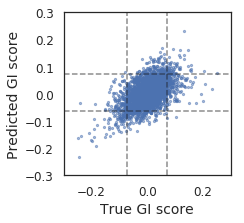

In [47]:
plt.figure(figsize=[3,3])
plt.scatter(upper_triangle(emap_baseline), upper_triangle(maps[(10, 0)]['emap']), s=5, alpha=0.5)

s = upper_triangle(emap_baseline)
lo, hi = s.quantile([0.05, 0.95])
# extremes = (s < lo)| (s > hi)
plt.plot([lo, lo], [-0.3, 0.3], 'k--', alpha=0.5)
plt.plot([hi, hi], [-0.3, 0.3], 'k--', alpha=0.5)


s = upper_triangle(maps[(10, 0)]['emap'])
lo, hi = s.quantile([0.05, 0.95])
plt.plot([-0.3, 0.3], [lo, lo], 'k--', alpha=0.5)
plt.plot([-0.3, 0.3], [hi, hi], 'k--', alpha=0.5)

plt.xlim([-0.3, 0.3])
plt.ylim([-0.3, 0.3])

plt.xlabel('True GI score')
plt.ylabel('Predicted GI score')
plt.savefig('./figures/prediction_scatter_with_quantiles.pdf', bbox_inches='tight')

These next two figures are merged together in Illustrator to make Fig. 6B.

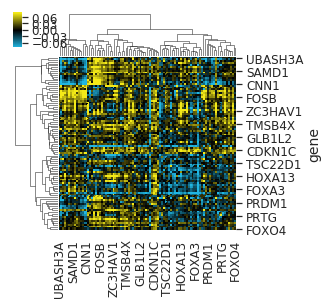

In [48]:
cg = sns.clustermap(maps[(10, 0)]['emap'],
                    row_linkage=Z_emap,
                    col_linkage=Z_emap,
                    cmap=plt.cm.get_cmap('BlueYellow'),
                    figsize=[4,4], vmin=-0.08, vmax=0.08)
cg.savefig('./figures/prediction_predicted_emap_emap_order.pdf')

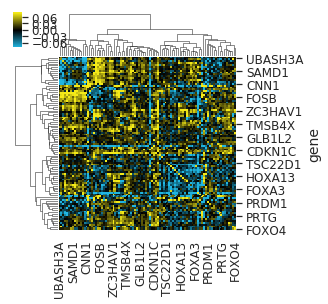

In [49]:
cg = sns.clustermap(emap_baseline,
                    row_linkage=Z_emap,
                    col_linkage=Z_emap,
                    cmap=plt.cm.get_cmap('BlueYellow'),
                    figsize=[4,4], vmin=-0.08, vmax=0.08)
cg.savefig('./figures/prediction_baseline_emap_emap_order.pdf')

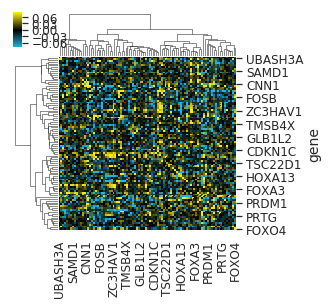

In [50]:
cg = sns.clustermap(emap_baseline - maps[(10, 0)]['emap'],
                    row_linkage=Z_emap,
                    col_linkage=Z_emap,
                    cmap=plt.cm.get_cmap('BlueYellow'),
                    figsize=[4,4], vmin=-0.08, vmax=0.08)
cg.savefig('./figures/prediction_prediction_error.pdf')

In [51]:
upper_triangle(maps[(10,0)]['emap']).corr(upper_triangle(emap_baseline), method='spearman')

0.512700804409362

# Block averaging of GI maps

Given a clustering, the routine below averages all GIs within the blocks that are defined by the intersection of clusters. E.g. GIs that fall into cluster 2 on the x axis and cluster 3 on the y axis will define one block.

In [52]:
import itertools

def threshold_emap(emap, clusters):
    mean_interactions = pd.DataFrame(index=pd.Index(sorted(clusters.unique())), columns=sorted(clusters.unique()))
    emap_correlation = emap.corr()
    emap_coherence = emap.copy()

    for pair in itertools.combinations_with_replacement(clusters.unique(), 2):
        genes_1 = clusters[clusters == pair[0]].index.tolist()
        genes_2 = clusters[clusters == pair[1]].index.tolist()
        mean_interactions.loc[pair[0], pair[1]] = emap.loc[genes_1][genes_2].mean().mean()
        mean_interactions.loc[pair[1], pair[0]] = emap.loc[genes_2][genes_1].mean().mean()
        
        avg_correlation_1 = emap_correlation.loc[genes_1][genes_2].mean().mean()
        avg_correlation_2 = emap_correlation.loc[genes_2][genes_1].mean().mean()
        for gene_1 in genes_1:
            for gene_2 in genes_2:
                emap_coherence.loc[gene_1][gene_2] = avg_correlation_1
                emap_coherence.loc[gene_2][gene_1] = avg_correlation_2
                    
    emap_thresholded = emap.copy()

    for pair in itertools.combinations_with_replacement(emap_thresholded.columns, 2):
        cluster1 = clusters.loc[pair[0]]
        cluster2 = clusters.loc[pair[1]]
        emap_thresholded.loc[pair[0], pair[1]] = mean_interactions.loc[cluster1, cluster2]
        emap_thresholded.loc[pair[1], pair[0]] = mean_interactions.loc[cluster2, cluster1]
    
    return emap_thresholded, emap_coherence, mean_interactions

Generate clusters used for block averaging

In [53]:
from scipy.cluster.hierarchy import fcluster, dendrogram, leaves_list

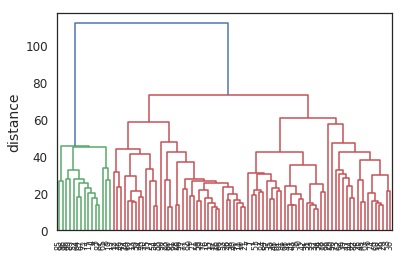

In [54]:
plt.ylabel('distance')
dendrogram(
    Z_emap,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [55]:
clusters = pd.Series(fcluster(Z_emap, 40, criterion='distance'),
                     emap_baseline.columns,
                     )

Now make the thresholded GI maps from the full data (baseline) and the prediction.

In [56]:
emap_baseline_thresh, emap_baseline_coherence, mean_interactions_baseline = threshold_emap(emap_baseline, clusters)

In [57]:
emap_pred_thresh, emap_pred_coherence, mean_interactions_pred = threshold_emap(maps[(10,0)]['emap'], clusters)

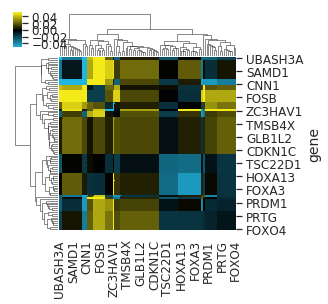

In [58]:
cg = sns.clustermap(emap_pred_thresh,
                    row_linkage=Z_emap,
                    col_linkage=Z_emap,
                    cmap=plt.cm.get_cmap('BlueYellow'),
                    figsize=[4,4], vmin=-0.05, vmax=0.05)
cg.savefig('./figures/prediction_block_averaged_prediction.pdf')

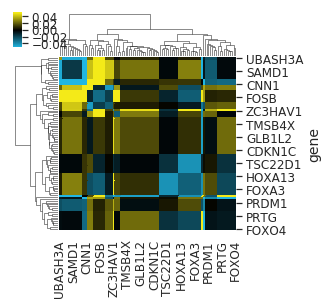

In [59]:
cg = sns.clustermap(emap_baseline_thresh,
                    row_linkage=Z_emap,
                    col_linkage=Z_emap,
                    cmap=plt.cm.get_cmap('BlueYellow'),
                    figsize=[4,4], vmin=-0.05, vmax=0.05)
cg.savefig('./figures/prediction_block_averaged_true.pdf')

# Prediction performance

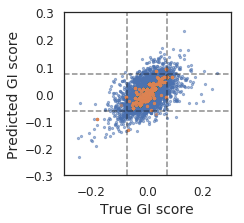

In [60]:
plt.figure(figsize=[3,3])
plt.scatter(upper_triangle(emap_baseline), upper_triangle(maps[(10, 0)]['emap']), s=5, alpha=0.5)
plt.scatter(upper_triangle(emap_baseline_thresh), upper_triangle(emap_pred_thresh), s=5, alpha=0.5)

s = upper_triangle(emap_baseline)
lo, hi = s.quantile([0.05, 0.95])
plt.plot([lo, lo], [-0.3, 0.3], 'k--', alpha=0.5)
plt.plot([hi, hi], [-0.3, 0.3], 'k--', alpha=0.5)


s = upper_triangle(maps[(10, 0)]['emap'])
lo, hi = s.quantile([0.05, 0.95])
plt.plot([-0.3, 0.3], [lo, lo], 'k--', alpha=0.5)
plt.plot([-0.3, 0.3], [hi, hi], 'k--', alpha=0.5)

plt.xlim([-0.3, 0.3])
plt.ylim([-0.3, 0.3])

plt.xlabel('True GI score')
plt.ylabel('Predicted GI score')
plt.savefig('./figures/prediction_scatter_with_quantiles.pdf', bbox_inches='tight')

In [61]:
upper_triangle(emap_baseline_thresh).corr(upper_triangle(emap_pred_thresh), method='spearman')

0.8260346889981248

Making all the block-averaged GI maps...

In [62]:
from tqdm import tqdm_notebook as progress

In [63]:
thresholded_emaps = dict()
thresholded_corrs = dict()
thresholded_spearmans = dict()

for key, em in progress(maps.iteritems(), total=len(maps)):
    em_thresh, _, _ = threshold_emap(em['emap'], clusters)
    thresholded_corrs[key] = upper_triangle(emap_baseline_thresh).corr(upper_triangle(em_thresh))
    thresholded_spearmans[key] = upper_triangle(emap_baseline_thresh).corr(upper_triangle(em_thresh), method='spearman')

HBox(children=(IntProgress(value=0, max=250), HTML(value=u'')))

In [64]:
df = pd.Series(thresholded_spearmans).to_frame()
df.columns = ['value']
df = df.reset_index().rename(columns={'level_0': 'fraction', 'level_1': 'it'})

In [65]:
corrs_df = pd.read_csv('./data_sharing/maps_random_sampling_corrs.csv', index_col=[0])
corrs_df.columns = corrs_df.columns.astype(int)

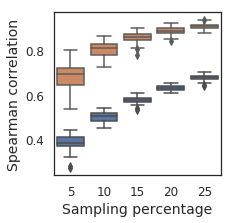

In [66]:
plt.figure(figsize=[3,3])
sns.boxplot(x='variable', y='value', data=corrs_df.melt(), color=sns.color_palette()[0])
sns.boxplot(x='fraction', y='value', data=df, color=sns.color_palette()[1])

plt.xlabel('Sampling percentage')
plt.ylabel('Spearman correlation')

plt.savefig('./figures/prediction_performance_with_block_averaged.pdf', bbox_inches='tight')

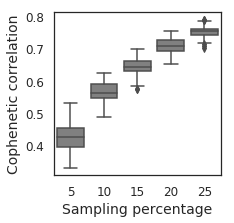

In [67]:
cophen_corrs = {k: np.corrcoef(pdist(v['emap'], metric='correlation'),
                               pdist(emap_baseline, metric='correlation'))[0, 1] for k,v in maps.iteritems()}

plt.figure(figsize=[3,3])
sns.boxplot(x='variable', y='value', data=pd.Series(cophen_corrs).unstack().T.melt(), color='gray')

plt.xlabel('Sampling percentage')
plt.ylabel('Cophenetic correlation')
plt.savefig('./figures/prediction_performance_profile_correlations.pdf', bbox_inches='tight')

In [68]:
from sklearn.metrics import recall_score

def extrema(s, quantile=0.1):
    if isinstance(s, pd.Series):
        min_ext, max_ext = s.quantile([quantile, 1 - quantile])
    elif isinstance(s, pd.DataFrame):
        min_ext, max_ext = s.stack().quantile([quantile, 1 - quantile])
    return (s < min_ext) | (s > max_ext)

def gene_extrema(df):
    return pd.DataFrame({k: extrema(col) for k, col in df.iteritems()})

In [69]:
baseline_extrema = upper_triangle(extrema(emap_baseline))
gene_extrema_random_sampling = {k: upper_triangle(extrema(v['emap']))for k, v in maps.iteritems()}

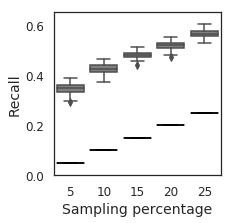

In [70]:
plt.figure(figsize=[3,3])
sns.boxplot(x='variable', y='value',
            data=pd.Series({k: recall_score(baseline_extrema, v) for k, v in gene_extrema_random_sampling.iteritems()}).unstack().T.melt(),
            color='gray')
sns.boxplot(x='variable', y='value',
            data=pd.DataFrame({'variable': [5, 10, 15, 20, 25], 'value': [0.05, 0.10, 0.15, 0.20, 0.25]}),
            color='black')

plt.xlabel('Sampling percentage')
plt.ylabel('Recall')
plt.ylim([0, 0.65]);
plt.savefig('./figures/prediction_recall_10pc_quantile.pdf', bbox_inches='tight')